# Week 5: Interpretability 1: filters, activations and saliency mapping

Tutorial by Cher Bass and Emma Robinson 

This week we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization with PyTorch hooks
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Gradient Class Activation Maps (grad-CAM)

In this first notebook we will look at simple network independent solutions for feature and activation visualisation, as well as occlusion-based saliency techniques

## Importing

The first thing we need to do is import a package called `visualizations`. This was uploaded to Keats the the Notebooks folder. Please upload that to your drive and then specify the path to where you put in the cell below. This will allow you to import it into this notebook.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

# STUDENTS UPLOAD the Notebooks folder to your drive and specify the path to where you have placed the visualisations package folder
%cd /content/drive/My\ Drive/Colab\ Notebooks/AdvancedML/2021/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/AdvancedML/2021


Now import the modules you need from torch and the visualization package by running the cell below.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.guided_backprop import GuidedBackprop
#from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Exercise 1. Weights Visualization

One of the first things you can visualize in your network is your networks weight tensors. These weights kernels reflect the lernt convolutional kernesl which are optimised during training> They can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [29]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see from the print output (above) that the network is made up of two sequential containers: 1) `features` (the convolutional layers) and 2) `classifier` (the linear layers).

### **Example:** 

To visualize the convolutional weights for some layer of a specific seqential container (e.g. `container`) of a network (e.g. `net`) : we must use the following notation:

```python 
# to return layer
layer=net.container[layer_num]
 # to return weights tensor of a layer
weight_tensor = net.container[layer_num].weight.data
```

**Note that layer id `layer_num` should correspond to a *convolutional* layer (e.g. 0, 3, 6, 10) otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [30]:
def plot_filters_single_channel(t,channels_to_plot,kernels_to_plot):
    

    print('printing {} kernels for each of the first {} filters '.format(kernels_to_plot,channels_to_plot))
    #total kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t,kernels_to_plot=60):
    
    print('printing the first {} 3D filters in RGB '.format(kernels_to_plot))
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols+1
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

**Ex 1.1** using the generic example given above,  edit the function `plot_weights` function to return the weights tensor for a given convolutional layere

1. Select the convolutional `layer` from alexnets `features` container corresponding to `layer_num`
2. Return the `weight_tensor` for this layer
3. run this function to return features from  `layer_num`=0

<class 'torch.nn.modules.container.Sequential'>
This layers learns 64 filters each with 3 kernels
printing the first 60 3D filters in RGB 


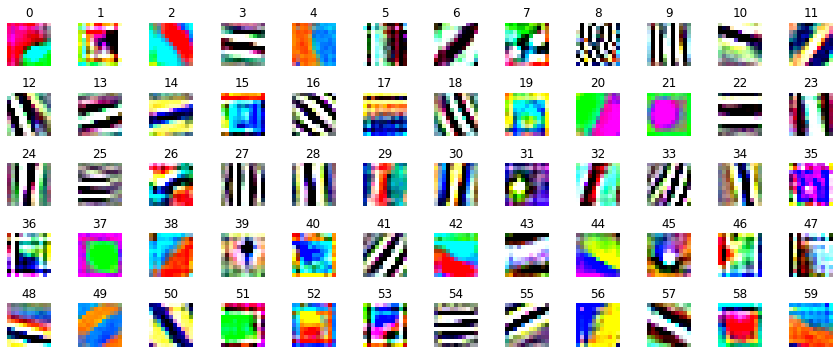

In [31]:
def plot_weights(container, layer_num,num_filter=10,num_kernels=30):
    '''
    plot_weights: a function to plot weights tensors from a network
                  this will print in RGB if filter depth is 3 (i.e. first layer)
                  else will print each kernel separately
    inputs:
          container: a sequnetial container for which the convolutional layers of the network are defined
          layer_num: choice of layer to visualise

    '''
    #Task 1.1.1 use variable layer_num to select a specific 
    layer = container[layer_num]
  
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # Task 1.1.2 return the weights tensor for this 'layer`
        weight_tensor = layer.weight.data
        print('This layers learns {} filters each with {} kernels'.format(weight_tensor.shape[0],weight_tensor.shape[1]))
        # if the weights tensor has 3 channels the it will plot filters in RGB
        if weight_tensor.shape[1]==3:
             # labelling each by filer id            
             plot_filters_multi_channel(weight_tensor,num_filter)    
        else:
            # else it will print each filter kernel separately
            # labelling each by filer.kernel (the filter id and the kernel id)
            plot_filters_single_channel(weight_tensor,num_filter,num_kernels)
        
    else:
        print("Can only visualize layers which are convolutional")


#Task 1.1  call the function to visualise layer 0 (in the first instance)
# to visualize weights for alexnets - first conv layer
plot_weights(alexnet.features, 0, 60)


**Ex 1.2** Explain 

1. What do the weights of your network represent? 
2. What is the difference between a kernel and a filter (**hint** see lecture 4)?
3. Layer 3 (the second convolution) has a weights matrix of size `[192, 64, 5, 5]`. What does each dimension represent? How many filters does it learn, how many kernels?
4. Try plotting the weights for different convolutional layers (changing code cell below). 
   - Try changing the numbers of filters and/or kernels printed per layer
   - What if anything can you interpret from each of these layer?
   - Do you think this approach is useful for intrepretation of deep networks? Why do you think that?
   



#### **Answer Questions in this cell**

1.

2.

3.


4



This layers learns 192 filters each with 64 kernels
printing 20 kernels for each of the first 10 filters 


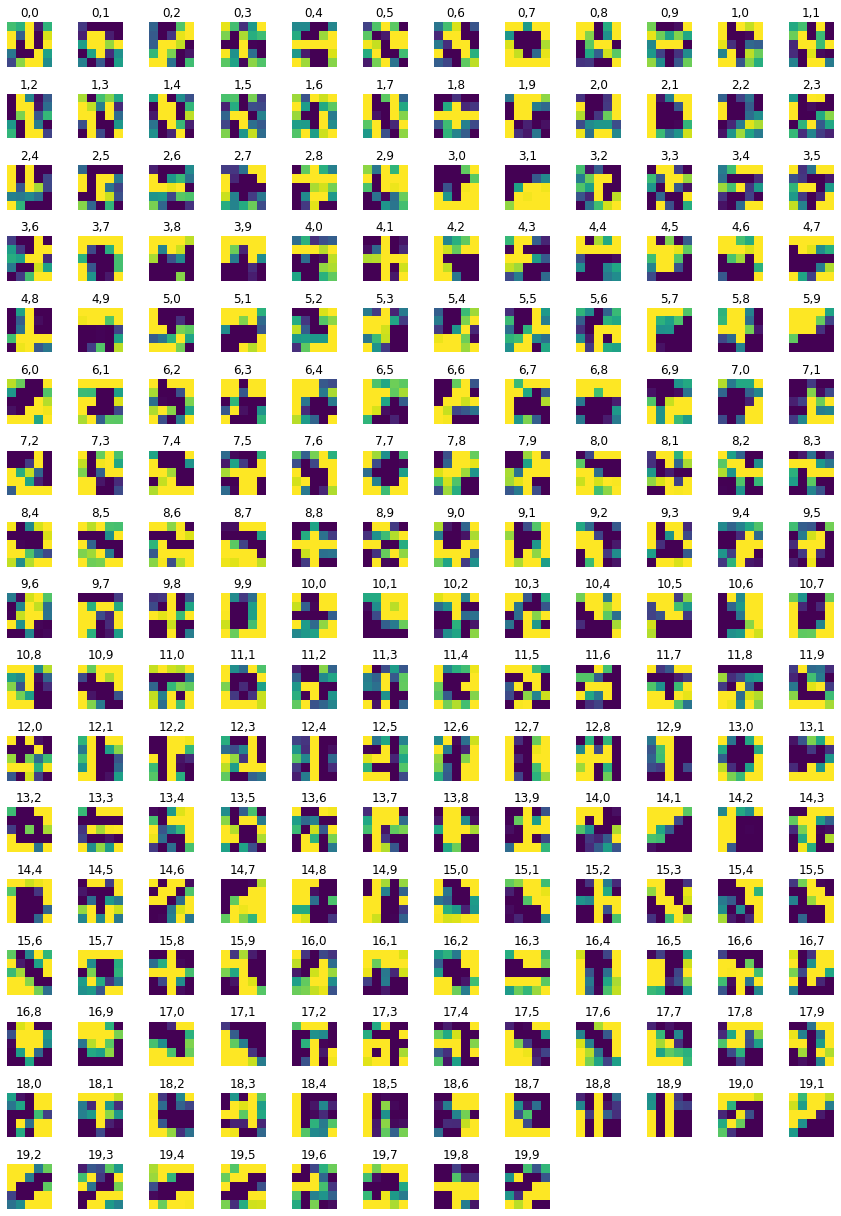

In [38]:
# Task 1.2.4 visualize weights for different convolutional layers
# wha can you interpret from this 
plot_weights(alexnet.features, 3, 10, 20)

## Exercise 2. Activation visualization with PyTorch Hooks

An alternative approach to examine what your network is learning, is to visualise your network's features or activations, i.e. the 'images' which are created following passing your inputs through a given convolutional layer (with relu)

Let's use MNIST for this example. Loading train and validation DataLoaders, and generating a similar basic convolutional network to which we used in Lecture 2:

In [39]:
mnist_train_dataset = datasets.MNIST(root = 'mnist_data/train', download= True, train = True, transform = transforms.ToTensor())
mnist_test_dataset = datasets.MNIST(root = 'mnist_data/test', download= True, train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 8, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 8, shuffle = True)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

In [40]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv1=nn.Conv2d(1, 10, 3)
        self.maxpool1=nn.MaxPool2d(2)
        self.dropout1=nn.Dropout2d()
        
        self.conv2=nn.Conv2d(10, 20, 3)
        self.maxpool2=nn.MaxPool2d(2)
        self.dropout2=nn.Dropout2d()
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            #nn.Softmax(),
        )
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)


net = MNIST_Model() 
print(net)
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


MNIST_Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (lin_blocks): Sequential(
    (0): Linear(in_features=500, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [41]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        
        # load data and labels to device
        data = data.to(device)
        labels = labels.to(device)
        
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = net(data)

        # calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()
        # 

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.330
[1,    11] loss: 2.314
[1,    21] loss: 2.317
[1,    31] loss: 2.352
[1,    41] loss: 2.339
[1,    51] loss: 2.333
[1,    61] loss: 2.298
[1,    71] loss: 2.275
[1,    81] loss: 2.284
[1,    91] loss: 2.327
[1,   101] loss: 2.356
[1,   111] loss: 2.244
[1,   121] loss: 2.268
[1,   131] loss: 2.235
[1,   141] loss: 2.309
[1,   151] loss: 2.310
[1,   161] loss: 2.272
[1,   171] loss: 2.311
[1,   181] loss: 2.297
[1,   191] loss: 2.320
[1,   201] loss: 2.290
[1,   211] loss: 2.295
[1,   221] loss: 2.289
[1,   231] loss: 2.340
[1,   241] loss: 2.296
[1,   251] loss: 2.289
[1,   261] loss: 2.306
[1,   271] loss: 2.312
[1,   281] loss: 2.273
[1,   291] loss: 2.269
[1,   301] loss: 2.261
[1,   311] loss: 2.248
[1,   321] loss: 2.313
[1,   331] loss: 2.288
[1,   341] loss: 2.271
[1,   351] loss: 2.250
[1,   361] loss: 2.314
[1,   371] loss: 2.272
[1,   381] loss: 2.295
[1,   391] loss: 2.285
[1,   401] loss: 2.264
[1,   411] loss: 2.232
[1,   421] loss: 2.250
[1,   431] 

### Understanding PyTorch Hooks

Hooks are functions with which you can modify or return different sub-components of your network. Returning the outputs of different layers (i.e. the activations - the goal of this section) is thus an excellent example. In general the point is that they are simply functions that are run whenever the `forward` or `backward` function of a `torch.Autograd.Function` object is called i.e. the `grad_fn` of a tensor (discussed in Lecture 2). 

You can register a function on a `Module` or a `Tensor` and are defined a priori as forward hooks or a backward hooks. Depending on which they are they will either be executed when a forward call is executed (forward hook) or a backward pass in run (backward hook). 

Let's look at using a forward and backward hook just for debugging (and thus printing) the output of a function (example taken from [the official PyTorch tutorials](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html))

A forward hook has the general form:

```python
model.conv_name.register_forward_hook(forward_hook_function)
```

With `forward_hook_function` being a user defined function of form:

```
def forward_hook_function(module, input,output):
```

And a backward hook has a general form

```python
model.conv_name.register_backward_hook(backward_hook_function)
```
With `backward_hook_function` being a user defined function of form:

```
def backward_hook_function(module,grad_input,grad_output):
```

Say we are interested in layer $l$. A forward hook function can look at inputs and outputs the layer during the forward pass i.e. the input activation from layer $l-1$ and the output activation for layer $l$. The backward pass can look at the inputs and outputs to the backward pass i.e. the incoming (input) gradient with respect to the parameters from the layer above $l+1$ and the outgoing (output) gradient with respect to the parameters of the current layer $l$.

Thus if we wish to print information about the input and output activations we can define a forward hook function to do this as:

In [42]:
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input type: ', type(input))
    print('output type: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())


We then register the forward hook as

In [43]:

print_forward_handle=net.conv1.register_forward_hook(printnorm)

#--------------------- ---- ----------------------------#
# performing forward pass
out = net(data)

Inside Conv2d forward

input type:  <class 'tuple'>
output type:  <class 'torch.Tensor'>

input size: torch.Size([8, 1, 28, 28])
output size: torch.Size([8, 10, 26, 26])


Note if you run this more than once it will print as many times as you run the cell (registering a new hook every time).

You may therefore want to consider removing as

In [44]:
print_forward_handle.remove()

 On the other hand and example of a backward hook function to return information about the layers gradients might be:

In [45]:
def printgradnorm(self, grad_input, grad_output):
    print('Inside ' + self.__class__.__name__ + ' backward')
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input type: ', type(grad_input))
    print('grad_output type: ', type(grad_output))
    print('')
    print('grad_input[0] size:', grad_input[0].size())
    print('grad_output[0] size:', grad_output[0].size())


print_backward_handle=net.conv2.register_backward_hook(printgradnorm)

# first need to run forward function and estimate loss
out = net(data)
err = loss_fun(out,labels)

print('loss:', err)
# then by running backward function the hook will be called
err.backward()

print_backward_handle.remove()

loss: tensor(0.0595, grad_fn=<NllLossBackward>)
Inside Conv2d backward
Inside class:Conv2d

grad_input type:  <class 'tuple'>
grad_output type:  <class 'tuple'>

grad_input[0] size: torch.Size([8, 10, 13, 13])
grad_output[0] size: torch.Size([8, 20, 11, 11])


**Exercise 2.1. Register hook to get network activations for a given input**

As hooks are functions that can be applied to the inputs and outputs of our forwards and backwards layers we can use them to return the activations of each layer.

**To do 2.1.1** Use hooks to return the activations of different layers of your network.

- Create a hook function to return the activations of the first convolutional layer.
  - should it be a forward hook or a backwards hook?
  - do you need to return the input or the outputs to the layer?

Note, while it would be sufficient to create a stand alone hook function ([see also this tutorial](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/) for an example), one other option may be to take a more generic approach: [saving the outputs of hooks to attributes of a bespoke class](https://www.kaggle.com/sironghuang/understanding-pytorch-hooks)


In [43]:
# Students to do create hook function (or class)
# the important thing here is that unlike the previous example they need some way to store the output
class activation_hook():
    def __init__(self):
        self.features={}  

    def run_hook_for_layer(self,module,layer_id):
        self.layer=layer_id
        self.hook = module.register_forward_hook(self.get_activation_hook)
        
    def get_activation_hook(self, module, input, output):
        self.features[self.layer]= output.detach()

    def close(self):
        self.hook.remove()

**Exercise  2.2 visualise acivations from hook** Use this class to return the activations of different layers of your network.
1. Create object `activation` (as class,list,dictionary) which will store activation tensor for different convolutional layer
2. Register a hook
3. Make a forwards or backwards pass (depending on which type of hook you think is appropriate) 
4. Plot each activation for this layer; how many would you expect?


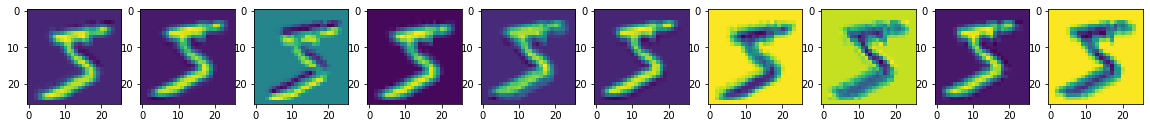

In [44]:
#--------------------- Task 2.2.2 ----------------------------#
# 2.2.1 Create a hook on the first convolutional layer
activation=activation_hook()
# 2.2.2
activation.run_hook_for_layer(net.conv1,'conv1')
#--------------------- ---- ----------------------------#

# take a single example from the dataset
data, _ = mnist_train_dataset[0]
data = data.to(device) # push to device
data.unsqueeze_(0) # ignore batch axis

# Task 2.2.3 Run forward pass on single example
# this will apply the hook and to save the relevant activations
output = net(data)

# Task 2.2.4 Plot all activations for this layer
# storing the resulting activation tensor to the act variable
act = activation.features['conv1'].squeeze()

num_maps=10 # number of activation maps (determined from network structure)

#plotting by looping over all channels
fig, axarr = plt.subplots(1,num_maps,figsize=(20,20))
for idx in np.arange(num_maps):
    axarr[idx].imshow(act.cpu()[idx])


**Ex 2.2 (continued)** 
5. Try changing the convolutional layer
6. How can you interpret the activations of different layers? What does that mean with respect to the relative importance of different parts of your image?


**Task 2.2.6 answer:**

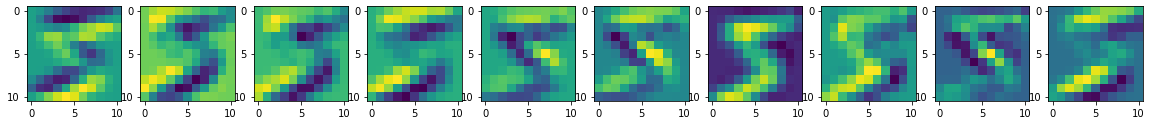

In [48]:
#--------------------- Task 2.2.1 ----------------------------#
# Create a hook on the first convolutional layer
activation.run_hook_for_layer(net.conv2,'conv2')
#--------------------- ---- ----------------------------#

# take a single example from the dataset
data, _ = mnist_train_dataset[0]
data = data.to(device) # push to device
data.unsqueeze_(0) # ignore batch axis

# Task 2.2.2 Run forward pass on single example
# this will apply the hook and to save the relevant activations
output = net(data)

# task 2.2.3 store the resulting activation tensor to the act variable
act = activation.features['conv2'].squeeze()

# Task 2.2.4 how many activation maps should we expect?
num_maps=10
fig, axarr = plt.subplots(1,num_maps,figsize=(20,20))
for idx in np.arange(num_maps):
    axarr[idx].imshow(act.cpu()[idx])

## Feature Attribution (saliency mapping)

Saliency mapping techniques seek to generate heatmaps which highlight which parts of an image are important for activation.

### Exercise 3: Saliency by occlusion

The most simple approach to saliency mapping is to perform occlusion. This works by greying out (setting to 0.5) patches of pixels for an image to see what impact this has on classification. Let's return a batch of images from our validation DataLoader and visualise them

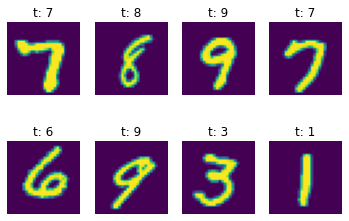

In [45]:
def plot_MNIST(images,labels):
    rows = 2
    columns = 4
    classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
    # plot y_score - true label (t) vs predicted label (p)
    fig2 = plt.figure()
    for i in range(8):
        fig2.add_subplot(rows, columns, i+1)
        plt.title('t: ' + classes[labels[i].cpu()])
        img = images[i] / 2 + 0.5     # this is to unnormalize the image
        img = torchvision.transforms.ToPILImage()(img.cpu())
        plt.axis('off')
        plt.imshow(img)
    plt.show()


im_batch, lab_batch=next(iter(test_loader)) # view one batch
im_batch = im_batch.to(device)
plot_MNIST(im_batch,lab_batch)

The first thing we need to do is run inference on the images without occlusion

In [46]:
#running inference on the images without occlusion

# pretrained model
outputs = net(im_batch)

# #passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#assigning the predicted label from the maximum softmax output
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

print('Predictions = ', pred,'max prob',prob_no_occ)

Predictions =  tensor([7, 8, 9, 7, 6, 9, 3, 1]) max prob 0.9999995231628418


Now, let's look at the effect of zeroing (or greying out) blocks of pixels in our image.

Similar to the patch based selection that we saw in lecture 4, we are constrained to select only patches which fit in our image (which means that number of points on which we can start each patch is constrained by the width and height of our patch). This means that the output size will be smaller than the original image size by a factor of: (h-p)/s; where, h is the height (or width), p is the patch size and s is the chosen stride.

Let's start create an image with an occluded patch in the centre. 

#### **To do 3.1 Create a function which occludes a patch from an image**

1. set all pixels of patch (starting at height: `heigh_start` and width: `width_start`, and of size: `patch_size` to 0.5
  - **note** if the patch_size exceeds the dimensions on any axis - just set the available space to zero (otherwise the results of Ex 3.2 will have shape less thana the original image). This is equivalent to padding the operation.

In [47]:
from math import ceil

# Student to do
# 
def occlude_image(image, model, height_centre,width_centre,patch_size,label):
    ''' 
    Creates a copy of the image and occludes a patch 
    input:
    image (Pytorch tensor): image to be occluded
    model: Pytorch network model 
    height_centre=centre of patch on height dimension
    width_centre= centre of patch on width dimension
    patch_size: size of patch
    
    output: 
    probability
    '''

    #now make a new copy of image in memory;
    # the detach() method creates a copy of the tensor without copying it computation graph (i.e. sets requires_grad to false) 
    # clone creates a copy of tensor with new location in memory
    occluded_image = image.detach().clone()
    
    # estimate the start and end dimensions of the patch
    # allow for patches to be centred at all locations irrespective of whether patch fits fully or not i.e. pad
    height_start=height_centre-ceil(patch_size/2)
    width_start=width_centre-ceil(patch_size/2)

    if height_start <0:
      height_start=0
    if width_start < 0:
      width_start=0

    height_end=height_start+patch_size
    width_end=width_start+patch_size

    if height_end >= occluded_image.shape[1]:
      height_end=occluded_image.shape[1]-1
    if width_end >= occluded_image.shape[2]:
      width_end=occluded_image.shape[2]-1
    
    # Task 3.1: grey out a patch of the image (by replacing the intensity values in the patch with 0.5 value)
    # use the parameters supplied to determined patch coordinates
    occluded_image[:,height_start:height_end,width_start:width_end]=0.5
    
    return occluded_image

2. Pass the full image through the network and estimate the probability of the network predicting the correct label (return softmax output corresponding to the correct label)
3. Now occlude the image and make another forward pass; how does occlusion impact the prediction accuracy?


**Note** 
- forward pass expects an input tensor of shape $B\times C\times H\times W$ where $B$ represents the batch size, $C$ the number of channels and $H$ and $W$ the height and width (**hint** perhaps use [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html))
-you will need to use `nn.functional.softmax()` on the output from your network. This will return a probability for each label (summing to one over all classes

True label: 7 original probability: 0.9963741898536682 occluded probability: 0.016789328306913376


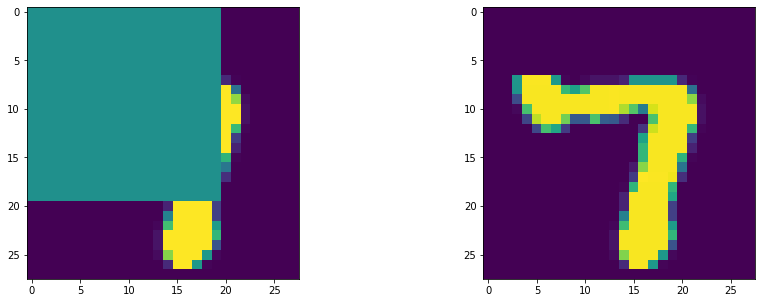

In [48]:
true_label=lab_batch[0].numpy()
patch_size=20
height_start=8
width_start=8

# Task 3.1.2 pass the image through a forward pass  and estimate the probability of prediction of the True label (2 lines)
# remember the network will be expect an input of shape BxCxHxW where B is batch size and C is number of channels
# use nn.functional.softmax to return a probability
output_full=net(im_batch[0].unsqueeze(0))
full_prob=nn.functional.softmax(output_full,dim=1)[0,true_label]

# Task 3.1.2 pass the image through the occlusion function and make forward pass (2 lines)
occluded_image=occlude_image(im_batch[0], net, height_start,width_start,patch_size,true_label)
output_occluded=net(occluded_image.unsqueeze(0))
# Task 3.1.3 return label probabilities for this prediction using softmax
occluded_prob=nn.functional.softmax(output_occluded,dim=1)[0,true_label] 

print('True label: {} original probability: {} occluded probability: {}'.format(true_label, full_prob,occluded_prob)) 

# plot
fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
img = torchvision.transforms.ToPILImage()(occluded_image[0].cpu())
plt.imshow(img)
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(im_batch[0].cpu())
plt.imshow(img)
plt.show()

You will see that, not unexpectedly grey out the part of the image which contains the number will dramatically reduce the probability of selecting the correct label.

Thus, occlusion presents us a network indepedent way of generating a map of regional saliencies. All we need to do is **occlude patches centered at all feasible locations** in the image; then we can generate a heatmap of label probabilities estimated for each of these patches/locations. 


#### **Exercise 3.2 Create occlusion based saliency map**

Create a function to iterate across an image to generate patch predictions at each feasible location.



In [49]:
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50,  occ_pixel = 0.5):
     '''
       function to iterate occlusion mapping for all locations in an image
       in order to return a heatmap
       input:
            model - the trained model
            image - the input image to occlude
            label - the true image label
            occ_size - the patch size
            occ_pixel - the value to fill the patch with
      
      output:
           heatmap (torch array) - same shape as image,
                                 - value at each grid location =  label probabilities corresponding to result of occluding a patch centred at the corresponding image location

    '''
    #create a zero image with shape equal to the image
    heatmap = torch.zeros((image.shape[1],image.shape[2]))
    
    #iterate all the pixels in each column
    for h in range(image.shape[1]):
        for w in range(image.shape[2]):
            
            # occlude image for this patch
            occluded_image=occlude_image(image, model, h,w,occ_size,label)
            # make forward pass and return softmax probability
            output_occluded=net(occluded_image.unsqueeze(0))
            occluded_prob=nn.functional.softmax(output_occluded,dim=1)[0,true_label] 
            #setting the heatmap location to probability value
            heatmap[h, w] = occluded_prob



    return heatmap



**To do** now run for the test image - you may need to change the patch size to get an interpretable result

In [53]:
print(pred[0],pred[0].type)
image=im_batch[0]
heatmap = occlusion(net, image, lab_batch[0].item(),20, 1)
print(heatmap.shape)

tensor(7) <built-in method type of Tensor object at 0x7f2c8ed04c60>
torch.Size([1, 28, 28]) 7
torch.Size([28, 28])


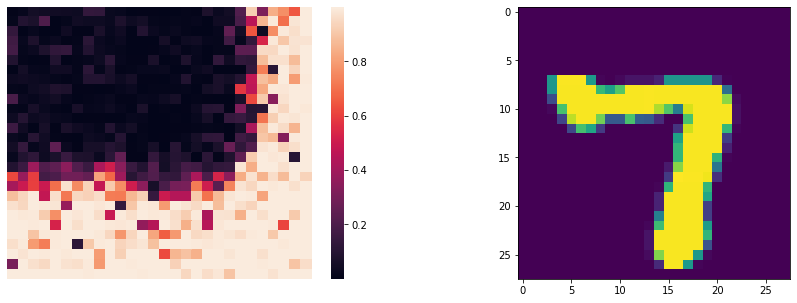

In [54]:
import seaborn as sns

fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(image[0].cpu())
plt.imshow(img)
plt.show()

### **Exercise 4. Gradient visualization with Guided backpropagation**

So occlusion can be an effective method for returning saliency maps but for large images it can be computationally costly compute. Therefore several alternative methods have been proposed which instead seek to backpropagate gradients from output neurons to the locations in the image which contribute most significantly to the prediction. 

The first method we will look at will be Guided Backpropation, which is an extension of DeconvNet to generalise to all convolutional networks (which downsample through strided convolutions). The Deconvnet visualises activations pertaining to specific classes, by pushing gradient activations backwards from through the network through a series of unpooling, relus (to zero negative gradients) and inverse convolutions (implemented by applying transposed filters)

For [Guided Backpropagation](https://arxiv.org/pdf/1412.6806.pdf), the outputs of relu operations at each layer are pushed backwards, guided by masks which summarise the forwards and backwards relu. Thus these zero contributions from any locations with negative activations or negative gradients to return locations in the image that contribute positively to the prediction.

<figure align="center">
<img src="https://drive.google.com/uc?id=14kCGfNgojzkwDa5k44RyiqsBukoS7Ls1" alt="Drawing" width="800px;"/>
</figure>

You can find the implementation of guided backpropagation in the `vizualizations` package folder that you uploaded to run this notebook `/visualizations/src/guided_backprop.py`.

#### **Exercise 4.1 first comment each line in `GuidedBackprop.update_relus(self)`**

To cement your understanding of the Guided Backpropagation method, comment each line of the function `GuidedBackprop.update_relus(self)`. This uses hooks to extract the activations and gradients of each relu layer. These are used to mask the relu gradients and push them back towards the input pixel space.

**To do** Copy and paste below the line which combines the forward and backwards masking of negative gradients below

**Answer 4.1:**

```
# copy here the line of code which combines forwards and backwards masking of gradients is

```




**Now, run guided backpropagation for a given input image.**

The `visualizations` package is specifically designed to visualise the layers of PyTorch pretrained networks. Thus the function `misc_functions.get_example_params()` function loads a pretrained AlexNet and returns a preprocessed image `prep_img`,as well as it's target label.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224]) (224, 224, 3)


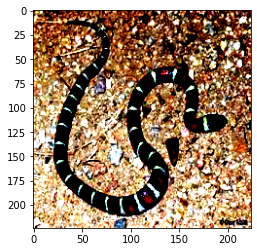

In [5]:
target_example = 0  
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

im_array=prep_img[0].detach().numpy()
print(prep_img.shape,np.moveaxis(im_array, 0, -1).shape)
plt.imshow(np.moveaxis(im_array, 0, -1))
plt.show()

An instance of the guidedbackprop class can be created using:

In [7]:
#--------------------------------------------------------- Guided backprop---------------------------------------------------
# Guided backprop
GBP = GuidedBackprop(pretrained_model)


Gradients specific to a particular input image, and class may be generated using the method `GP.generate_gradients()`, which has the following steps:
 1. go through a forward pass with the image input, and generate an output
 2. backprop through the output
 3. get the gradients from the backprop
 
**Run:**

In [8]:
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

We can then plot the outputs. Note for RGB matplot lib expects channels on the 3rd axis so we need to reshape:

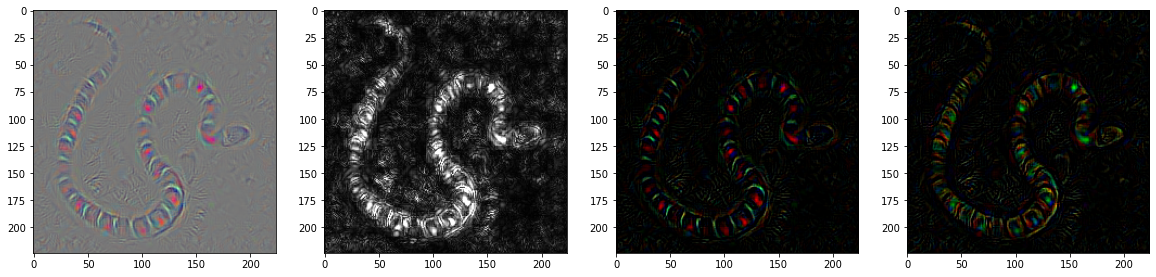

In [9]:
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)

### return normalise gradients and plot
guided_grads=normalise_gradient(guided_grads)
grayscale_guided_grads=normalise_gradient(grayscale_guided_grads)
pos_sal=normalise_gradient(pos_sal)
neg_sal=normalise_gradient(neg_sal)

fig2 = plt.figure(figsize=(20,10))
fig2.add_subplot(1, 4,1)
plt.imshow(np.moveaxis(guided_grads, 0, -1))
fig2.add_subplot(1, 4,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
fig2.add_subplot(1, 4,3)
plt.imshow(np.moveaxis(pos_sal, 0, -1))
fig2.add_subplot(1, 4,4)
plt.imshow(np.moveaxis(neg_sal, 0, -1))
plt.show()


#### **Exercise 4.2 Run guided backprop for different inputs, and classes**
You can do this by changing `target_example=` (there's 3 inputs available

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224]) (224, 224, 3)


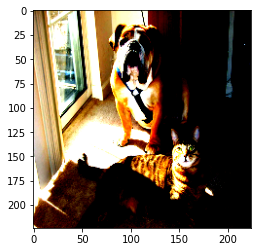

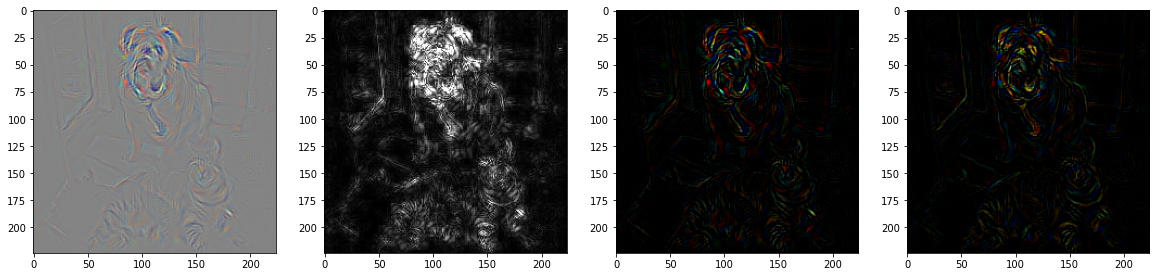

In [10]:
# --------------------------------------------- Task 4 --------------------------------------------------------
# write code here

target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

im_array=prep_img[0].detach().numpy()
print(prep_img.shape,np.moveaxis(im_array, 0, -1).shape)
plt.imshow(np.moveaxis(im_array, 0, -1))
plt.show()

# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)

### return normalise gradients and plot
guided_grads=normalise_gradient(guided_grads)
grayscale_guided_grads=normalise_gradient(grayscale_guided_grads)
pos_sal=normalise_gradient(pos_sal)
neg_sal=normalise_gradient(neg_sal)

fig2 = plt.figure(figsize=(20,10))
fig2.add_subplot(1, 4,1)
plt.imshow(np.moveaxis(guided_grads, 0, -1))
fig2.add_subplot(1, 4,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
fig2.add_subplot(1, 4,3)
plt.imshow(np.moveaxis(pos_sal, 0, -1))
fig2.add_subplot(1, 4,4)
plt.imshow(np.moveaxis(neg_sal, 0, -1))
plt.show()

## **Exercise 5 Gradient Class Activation Mapping (grad-CAM)**

[Grad-cam](https://arxiv.org/abs/1610.02391) allows extraction of occlusion-like saliency maps in a single pass, by creating a neuron importance score for a given target class. 

<figure align="center">
<img src="https://drive.google.com/uc?id=1POWiMnNv9t-WhLwV6qdFkE5KFGuPoVEQ" alt="Drawing" width="800px;"/>
</figure>

Specifically, it makes a forward pass, estimates the gradient of output activation ($A^k$), before the softmax and with respect to the target class ($y^c$), clamps this to one and then sets the gradient for all other classes to zero. It then estimates a **neuron importance score** by global average pooling over the spatial dimensions ($i,j$) of the channel:

$$\alpha_k^c=\frac{1}{Z} \sum_i \sum_j \dfrac{\partial y^c}{\partial A^k_{ij}}$$

This summarises the importance of a particular featuremap or channel to the prediction.

The final $\mathbb{R}^{u \times v}$ visualisation is then estimated from a weighted average over all activation map (where weights are given by the neuron importance scores). This is followed by a ReLU to clamp the visualisation to return only positive contributions. 

$$L^C_{Grad\_cam}=RELU(\sum_k \alpha_k^c A^k)$$


### **Exercise 5.1 Apply the code**

Run grad cam on the same examples used for Guided Backprop. What key differences do you observe.

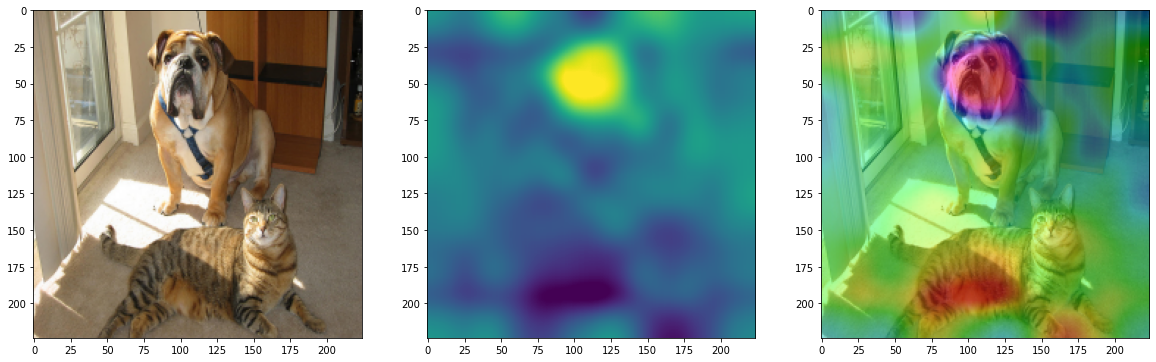

In [12]:
# STUDENTS CODE - run grad cam for visualizations example

#Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

# Create Grayscale activation map
heatmap, heatmap_on_image = apply_colormap_on_image(original_image, cam, 'hsv')

# plot
fig_cam = plt.figure(figsize=(20,10))
fig_cam.add_subplot(1, 3,1)
plt.imshow(original_image)
fig_cam.add_subplot(1, 3,2)
plt.imshow(cam)
fig_cam.add_subplot(1, 3,3)
plt.imshow(heatmap_on_image)

**Note** `target_example` is a picture of a dog and a cat but the `get_example_params` is hard coded to dog. If you would like to try different pictures the imagenet class label list can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

#### **Exercise Task 5.3 try changing the class of the image to 'tabby cat'**

You might also want to chose other images, or vary the target layer.

(224, 224) <class 'PIL.Image.Image'>


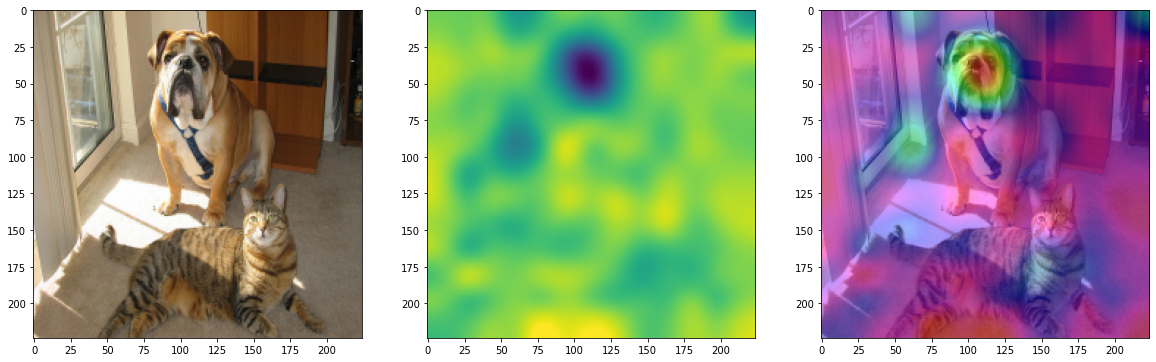

In [13]:
img_path = './visualizations/input_images/cat_dog.png'

target_class=280

original_image = Image.open(img_path).convert('RGB')
print(original_image.size,type(original_image))
prep_img = preprocess_image(original_image)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=9)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

## Create Grayscale activation map
heatmap, heatmap_on_image = apply_colormap_on_image(original_image, cam, 'hsv')

# plot
fig_cam = plt.figure(figsize=(20,10))
fig_cam.add_subplot(1, 3,1)
plt.imshow(original_image)
fig_cam.add_subplot(1, 3,2)
plt.imshow(cam)
fig_cam.add_subplot(1, 3,3)
plt.imshow(heatmap_on_image)

### **Exercise 6 (optional) Grad-CAM for MNIST**

Go back and change your MNIST network to make work with the visualization library. Remember it is set up to work with pretrained PyTorch networks which expect a very specific mopdular structure with the convolutional layers all defined in a nn.Sequential container called features and the linear layers defined in an nn.Sequential container called classfier. See the PyTorch AlexNet for reference.

Note

The vizualisations library assumes the networks have been trained on CPU so you either need to edit the grad_cam function to work for GPU, or (probably simpler in this case) just change runtime to CPU for this experiment.
when plotting you can make uses of the apply_colormap_on_image function shown above provided you first convert your input array to PIL image format, as shown below:
```
# plotting - first convert MNIST to a PIL image
org_im=Image.fromarray(np.uint8(im_batch[0,0,:,:].numpy()*255))
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
```



In [23]:
# STUDENTS CODE BELOW
# Define network
# initialise network, optimiser and loss function




In [ ]:
# STUDENT CODE TRAIN NETWORK

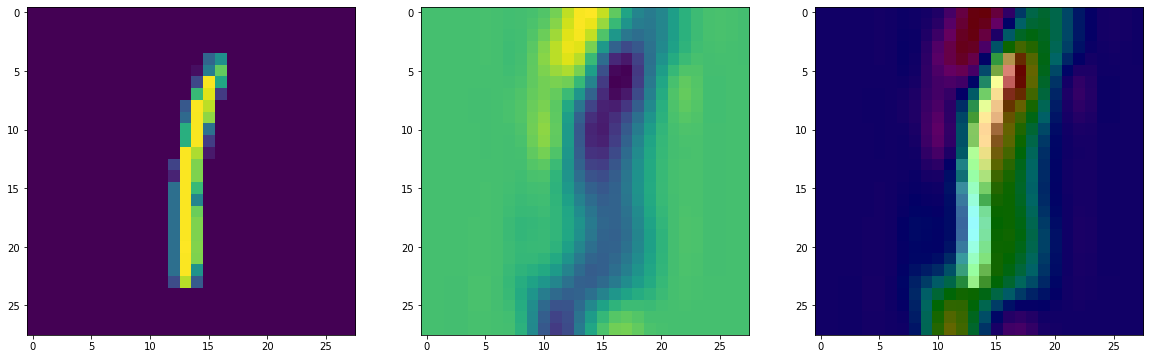

In [22]:
# STUDENT CODE - PLOTTING GRAD CAM FOR MNIST

# Source references

1. [visualizing-convolution-neural-networks-using-pytorch](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)
2. [DeepLearning-PadhAI](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP)